# Imports

In [67]:
from netCDF4 import Dataset 
import numpy as np 
import matplotlib.pyplot as plt 
from mpl_toolkits.basemap import Basemap 
import os 
from datetime import datetime, timedelta
import zipfile 
import pandas as pd
import statistics
#import statsmodels.stats.api as sms
from matplotlib.patches import Polygon


def draw_screen_poly( lats, lons, m):
    x, y = m( lons, lats )
    xy = list(zip(x,y))
    poly = Polygon( xy, facecolor='red', alpha=0.4 )
    plt.gca().add_patch(poly)


### load lat lon of nc files
path_latLon = "/all_mounts/masp17/bjuhls/bjuhls_massp17/LenaLaptevSea/grid_north_12km.nc" 
fh = Dataset(path_latLon, mode='r') 
lons = fh.variables['longitude'][:]# 
lats = fh.variables['latitude'][:] 


# Define ROI

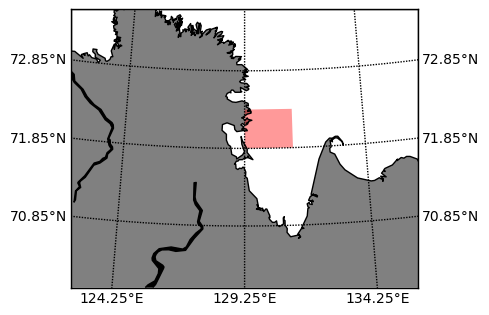

In [68]:
# define ROI
lon0=129.25 #western lon
lon1=131.25 #eastern lon
lat0=71.85 #southern lat
lat1=72.35 #northern lat

roi_coords=[(lon0, lon1),(lat0, lat1)] # lon0,lon1 lat0,lat1


### Plot defines ROI on map
plt.figure(figsize=(5,5), dpi=100)
m = Basemap(width=500000,height=400000,
            resolution='i',projection='tmerc',
            lat_0=lat0,lon_0=lon0)
lats_ROI = [ lat0, lat1, lat1, lat0 ]
lons_ROI = [ lon0, lon0, lon1, lon1 ]
m.fillcontinents(color='grey',lake_color='black')
m.drawcoastlines()
m.drawmapboundary()
m.drawparallels(np.arange(lat0 - 5,lat0 +5 ,1),labels=[1,1,0,0])
m.drawmeridians(np.arange(lon0-5,lon1+5,5),labels=[0,0,0,1])
draw_screen_poly( lats_ROI, lons_ROI, m )
plt.tight_layout()
#plt.savefig(PathFIGS + "SeaIceRois_Map.png", dpi=300)

plt.show()




# Extract SIC data in ROI

In [73]:
# create ROI filter
filt_ROI=np.logical_and(np.logical_and(lons>roi_coords[0][0],lons<roi_coords[0][1]),\
                np.logical_and(lats>roi_coords[1][0],lats<roi_coords[1][1]))
## create lists for Sea ice conc stats
Dates = []
IceRoi_mean = []
IceRoi_min = []
IceRoi_max = []
nValues= []
Ice_std = []
conf_95 = []
## iteratre throught the files and extract the data
pathOfDirs = "/all_mounts/masp17/bjuhls/bjuhls_massp17/LenaLaptevSea/Cersat/allyrs/"
print("Iterating through all the files and extract SIC data - may takes a while")
for ncfiles in sorted(os.listdir(pathOfDirs)):
    if ncfiles.endswith(".nc"):
        fh_data =Dataset(pathOfDirs + ncfiles, mode='r') 
        IceConc_tmp = fh_data.variables['concentration'][:] 
        IceConc_ROI = IceConc_tmp[0,filt_ROI]
        ## replace value 120
        IceConc = np.where(np.where(IceConc_ROI==127, np.nan, IceConc_ROI)==-128, np.nan, 
                           np.where(IceConc_ROI==127, np.nan, IceConc_ROI))
        #IceConc = IceConc_tmp127
        IceRoi_mean.append(np.nanmean(IceConc))
        #nValues.append(IceConc.count(axis=0))
        IceRoi_min.append(np.nanmin(IceConc))
        IceRoi_max.append(np.nanmax(IceConc))
        Ice_std.append(np.nanstd(np.where(np.array(IceConc) >=0, np.array(IceConc), np.nan)))
        Date = str(ncfiles[:-3])
        Dates.append(datetime.strptime(Date, '%Y%m%d'))
        
print("Done!")       


Iterating through all the files and extract SIC data - may takes a while


/home/bjuhls/.local/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in greater_equal
/home/bjuhls/.local/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice
/home/bjuhls/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: All-NaN slice encountered
/home/bjuhls/.local/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: All-NaN slice encountered


Done!


# Split data in years

In [74]:
df_ROI = pd.DataFrame(list(zip(Dates, IceRoi_mean, IceRoi_min, IceRoi_max, Ice_std)), 
               columns =['Date', 'IceRoi_mean', 'IceRoi_min', 'IceRoi_max', 'Ice_std']) 
df_ROI['year'] = df_ROI.Date.dt.year
df_ROI['Date'] = df_ROI.Date.dt.strftime('%m-%d')
df_ROI_unstacked = df_ROI.set_index(['year', 'Date']).IceRoi_mean.unstack(-2)
#df_ROI_unstacked_nValues = df_ROI.set_index(['year', 'Date']).nValues.unstack(-2)
df_ROI_unstacked_min = df_ROI.set_index(['year', 'Date']).IceRoi_min.unstack(-2)
df_ROI_unstacked_max = df_ROI.set_index(['year', 'Date']).IceRoi_max.unstack(-2)

#df_ROI_unstacked_std = df_ROI.set_index(['year', 'Date']).Ice_std.unstack(-2)

DOY = np.arange(1, len(df_ROI_unstacked.index.tolist() ) + 1, 1)

# Make baseline period stats

In [77]:
### between 1992 and 2020
YearStart = 1992
YearEnd = 2001

listyrs_1 = np.arange(YearStart, YearEnd + 1,1)
SIC_lists_period_1=[]
for i, e in enumerate(listyrs_1):
    #print(e)
    SIC_lists_period_1.append(df_ROI_unstacked[e])
    
Mean_period_1 = np.nanmean(SIC_lists_period_1, axis=0)
Min_period_1 = np.nanmin(SIC_lists_period_1, axis=0)
Max_period_1 = np.nanmax(SIC_lists_period_1, axis=0)
STD_period_1 = np.nanstd(SIC_lists_period_1, axis=0)

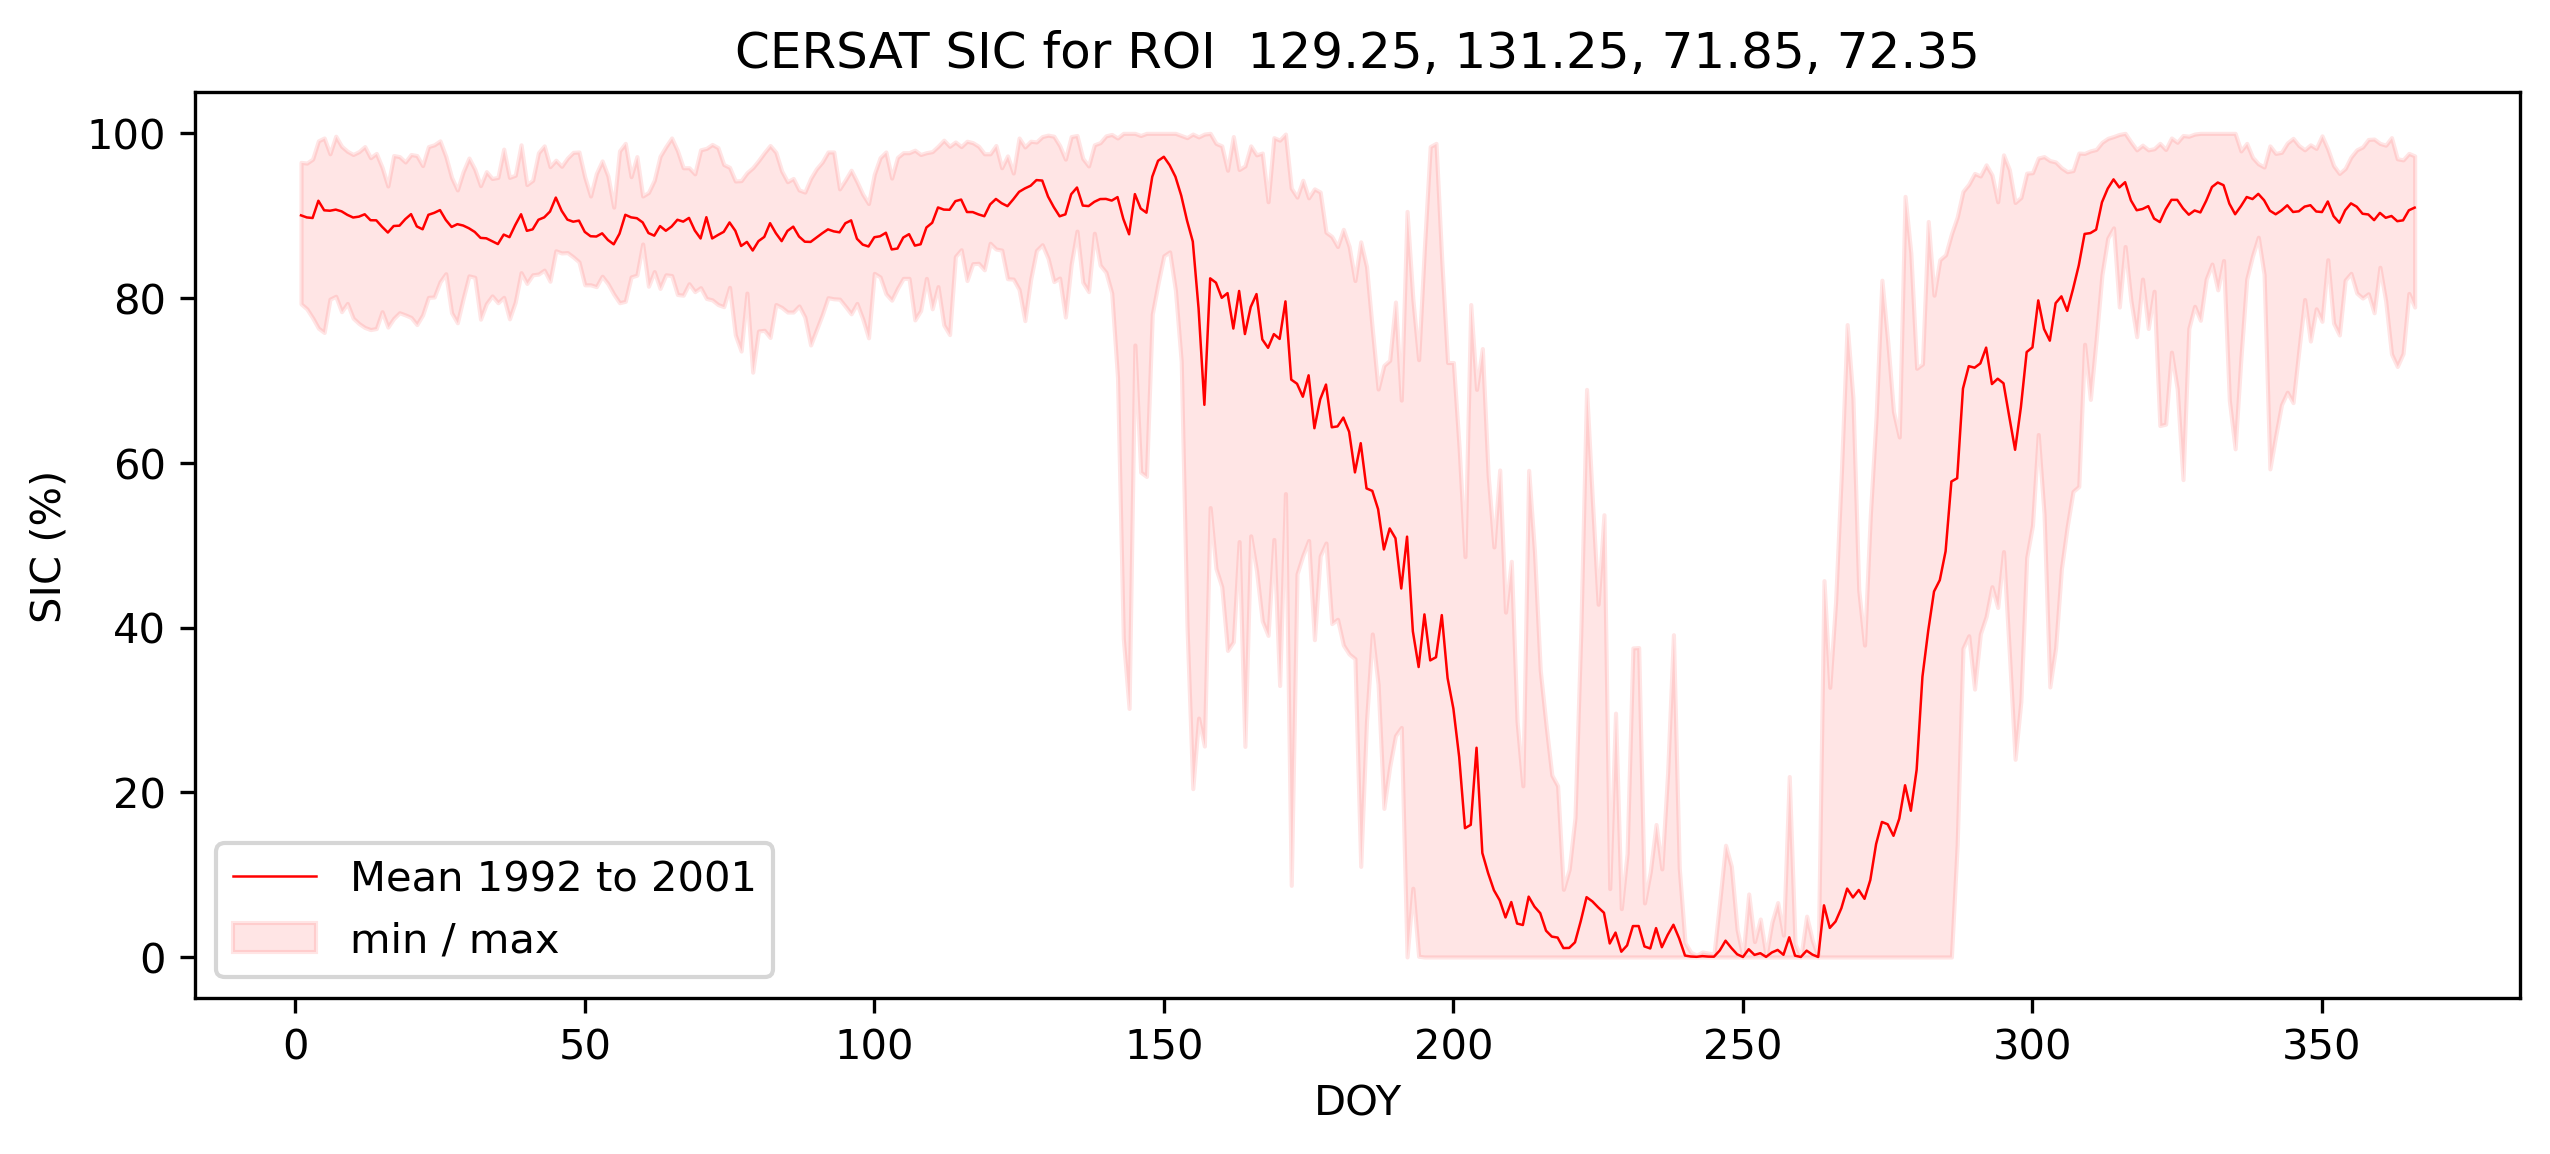

In [81]:
f, ((ax1)) = plt.subplots(1, 1,figsize=(10,4), dpi=300)

ax1.set_title("CERSAT SIC for ROI  " + str(lon0) + ", " + str(lon1)+ ", " + str(lat0) + ", " +str(lat1))
#ax1.plot(DOY, df_ROI_unstacked[2020] , "k-", lw=0.6, label="2020")
ax1.plot(DOY, Mean_period_1, "r-", lw=0.6, label="Mean 1992 to 2001")
ax1.fill_between(DOY, Min_period_1, Max_period_1, color="r", alpha=0.1, label="min / max")
#ax1.plot(DOY, mean_2002_to_2011_EAST , "m-", lw=0.6, label="Mean 2002 to 2011")
#ax1.fill_between(DOY, min_2002_to_2011_EAST, max_2002_to_2011_EAST, color="m", alpha=0.1)
#ax1.plot(DOY, mean_2012_to_2019_EAST , "b-", lw=0.6, label="Mean 2012 to 2019")
#ax1.fill_between(DOY, min_2012_to_2019_EAST, max_2012_to_2019_EAST, color="b", alpha=0.1)
#ax1.set_xticklabels([])

#ax1.set_ylim(0,100)

plt.legend(loc=3)
ax1.set_ylabel("SIC (%)")
ax1.set_xlabel("DOY")

plt.show()

# Plot 2d map with global data

define ROI for map

In [82]:
# define ROI for Map Plots
lon0=120 #western lon
lon1=135 #eastern lon
lat0=70 #southern lat
lat1=80 #northern lat

roi_coords=[(lon0, lon1),(lat0, lat1)] # lon0,lon1 lat0,lat1


filt_ROI=np.logical_and(np.logical_and(lons>roi_coords[0][0],lons<roi_coords[0][1]),\
                np.logical_and(lats>roi_coords[1][0],lats<roi_coords[1][1]))

#IceConc_ROI = IceConc_tmp[0,filt_ROI]

# Collect Global Data from a selected period 

In [83]:
### between 1992 and 2020
YYYYMMDD_Start = 20200101
YYYYMMDD_End = 20201231

IceConc_MapROI = []
Dates = []
pathOfDirs = "/all_mounts/masp17/bjuhls/bjuhls_massp17/LenaLaptevSea/Cersat/allyrs/"
print("Iterating through all the files and extract SIC data - may takes a while")
for ncfiles in sorted(os.listdir(pathOfDirs)):
    if ncfiles.endswith(".nc"):
        if int(ncfiles[:-3])>=YYYYMMDD_Start and int(ncfiles[:-3])<=YYYYMMDD_End:
            fh_data =Dataset(pathOfDirs + ncfiles, mode='r') 
            IceConc = fh_data.variables['concentration'][:] 
            IceConc_MapROI.append(IceConc)  
            Date = str(ncfiles[:-3])
            Dates.append(datetime.strptime(Date, '%Y%m%d'))

Iterating through all the files and extract SIC data - may takes a while


# Stats for global data

In [ ]:
for i, e in enumerate(IceConc_MapROI[:]):
          
    f, ((ax1 )) = plt.subplots(1, 1,figsize=(5,5), dpi=150)

    levels= np.linspace(0,100,100)
    plt.title(Dates[i].strftime('%D'), fontsize=20);

    
    m = Basemap(width=1200000,height=1000000,
                resolution='l',projection='tmerc',
                lat_0=lat0 + 5,lon_0=lon0, ax=ax1)   

    m.drawmapboundary(fill_color='black',linewidth=1.0)
    m.drawcoastlines(linewidth=0.25)  # Kuestenlinien
    m.fillcontinents(color='grey',lake_color='black')
    
    xx, yy = m(lons, lats)
    a = m.contourf(xx, yy, np.ma.masked_invalid(IceConc_MapROI[i][0,:,:]), vmin=0, vmax =100, levels=levels)
    m.colorbar(a)
    m.drawparallels(np.arange(lat0 - 15,lat0 +15 ,2),labels=[1,0,0,0])
    m.drawmeridians(np.arange(lon0-15,lon1+15,5),labels=[0,0,0,1])
    plt.tight_layout()
    plt.savefig(r"/all_mounts/masp26/SMOS_artic/BennetProjects/CACOON/PMann/_figs/SeaIce/SeaIceLaptev_" + Dates[i].strftime('%y%m%d') + ".png")
    #plt.show()
    plt.clf()

/home/bjuhls/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


# create GIF

In [ ]:
#### create a GIF
import glob
from PIL import Image
import natsort 

# filepaths
fp_in = "/all_mounts/masp26/SMOS_artic/BennetProjects/CACOON/PMann/_figs/SeaIce/SeaIceLaptev_*.png"
fp_out = "/all_mounts/masp26/SMOS_artic/BennetProjects/CACOON/PMann/_figs/SeaIceLaptev.gif"

# https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
img = [Image.open(f) for f in natsort.natsorted(glob.glob(fp_in))]
img[0].save(fp=fp_out, format='GIF', append_images=img,
         save_all=True, duration=150, loop=1)


#import moviepy.editor as mp

#clip = mp.VideoFileClip("/all_mounts/masp26/SMOS_artic/BennetProjects/Dissertation/_Defence/images/tenary/tenary_45.gif")
#clip.write_videofile("/all_mounts/masp26/SMOS_artic/BennetProjects/Dissertation/_Defence/images/tenary/tenary_45.mp4")